### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import text, sequence
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import bigrams
from string import punctuation
import re
from sklearn.model_selection import train_test_split

### Load the data

In [2]:
true_news = pd.read_csv("data/True.csv")
false_news = pd.read_csv("data/Fake.csv")

### Data visualization

In [3]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
false_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true_news["label"] = 1
false_news["label"] = 0

In [6]:
news = pd.concat([true_news, false_news], ignore_index=True)

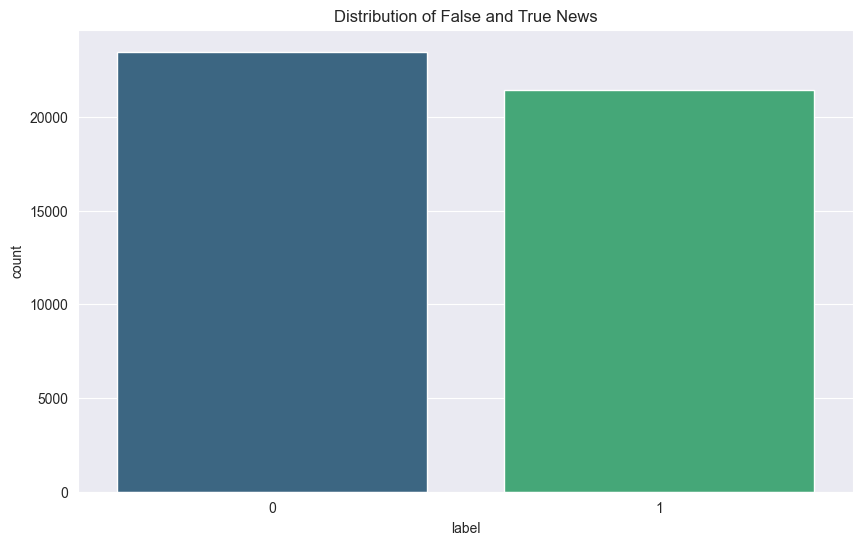

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', hue='label', data=news, palette='viridis', legend=False)
plt.title('Distribution of False and True News')
plt.show()

In [8]:
news.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [9]:
news.subject.value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

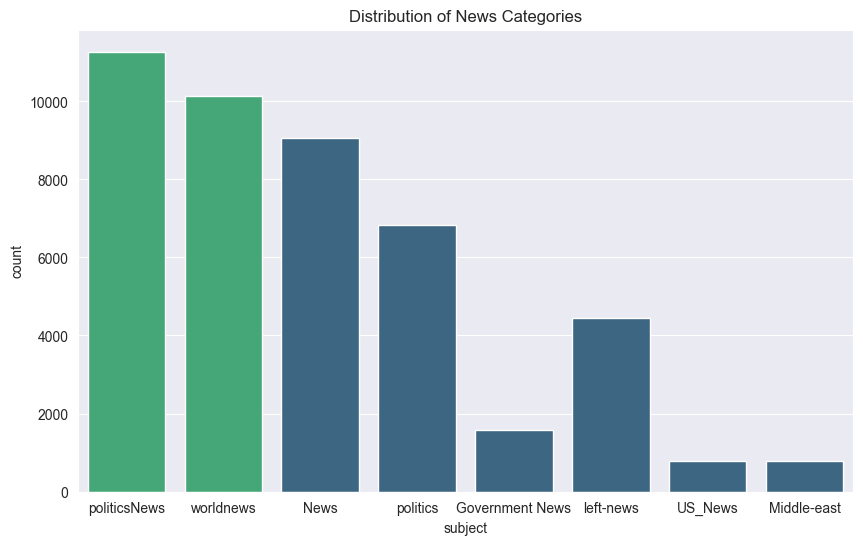

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', hue='label', data=news, palette='viridis', legend=False)
plt.title('Distribution of News Categories')
plt.show()

### Clean data

In [11]:
news["text"] = news["text"] + " " + news["title"]
del news["title"]
del news["subject"]
del news["date"]

In [12]:
news.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [13]:
stop_words = set(stopwords.words('english'))
punctuation = list(punctuation)
stop_words.update(punctuation)

In [14]:
def remove_html(content: str):
    return re.sub('<.*?>', '', content)

In [15]:
def remove_urls(content: str):
    return re.sub(r"http\S+|www.\S+", '', content)

In [16]:
def remove_stop_words(content: str):
    words = word_tokenize(content)
    return " ".join(word.strip() for word in words if word.strip().lower() not in stop_words)

In [17]:
def remove_brackets(content: str):
    return re.sub(r"[\[\]\(\){}]", '', content)

In [18]:
def clean_text(content: str):
    content = remove_html(content)
    content = remove_urls(content)
    content = remove_stop_words(content)
    content = remove_brackets(content)
    return content

In [19]:
news["text"] = news["text"].apply(clean_text)

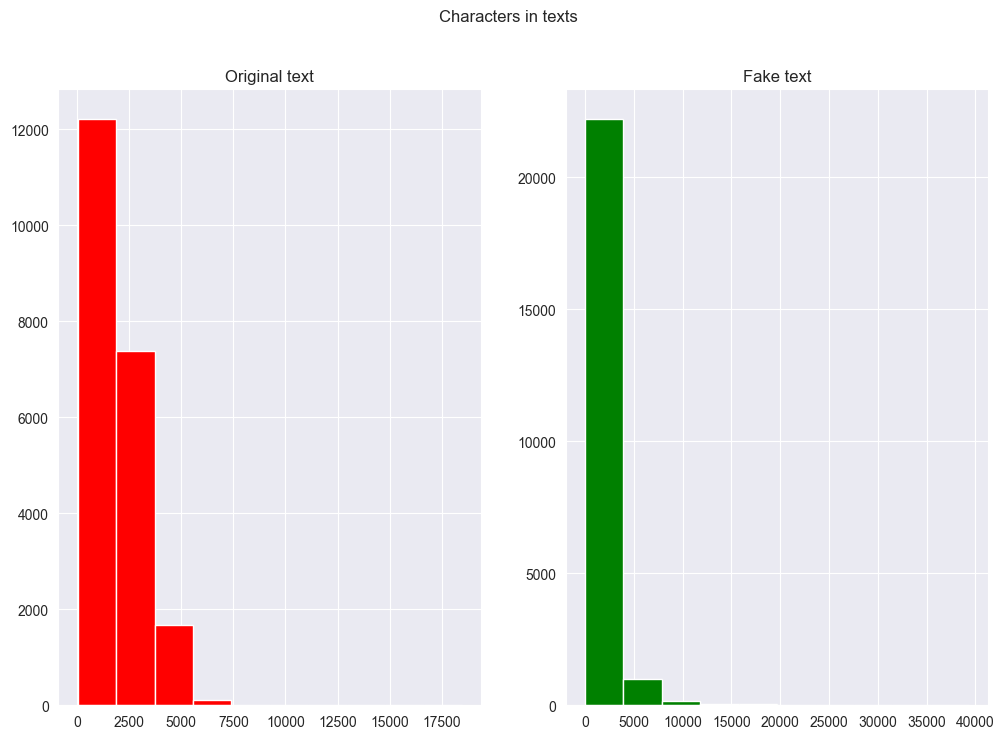

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

text_len = news[news["label"] == 1]["text"].str.len()
ax1.hist(text_len, color="red")
ax1.set_title("Original text")

text_len = news[news["label"] == 0]["text"].str.len()
ax2.hist(text_len, color="green")
ax2.set_title("Fake text")

fig.suptitle("Characters in texts")
plt.show()

In [21]:
def create_corpus(df):
    corpus = []

    for content in df["text"]:
        [corpus.append(word) for word in word_tokenize(content)]

    return corpus

In [22]:
news_corpus = create_corpus(news)

In [23]:
news_corpus[:10]

['WASHINGTON',
 'Reuters',
 'head',
 'conservative',
 'Republican',
 'faction',
 'U.S.',
 'Congress',
 'voted',
 'month']

In [24]:
news_freq_dist = FreqDist(news_corpus)

In [25]:
news_bigrams = list(bigrams(news_corpus))

In [26]:
x_train,x_test,y_train,y_test = train_test_split(news.text,news.label,random_state = 0)

In [27]:
max_features = 10000
max_len = 300

In [28]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)

In [29]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=max_len)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

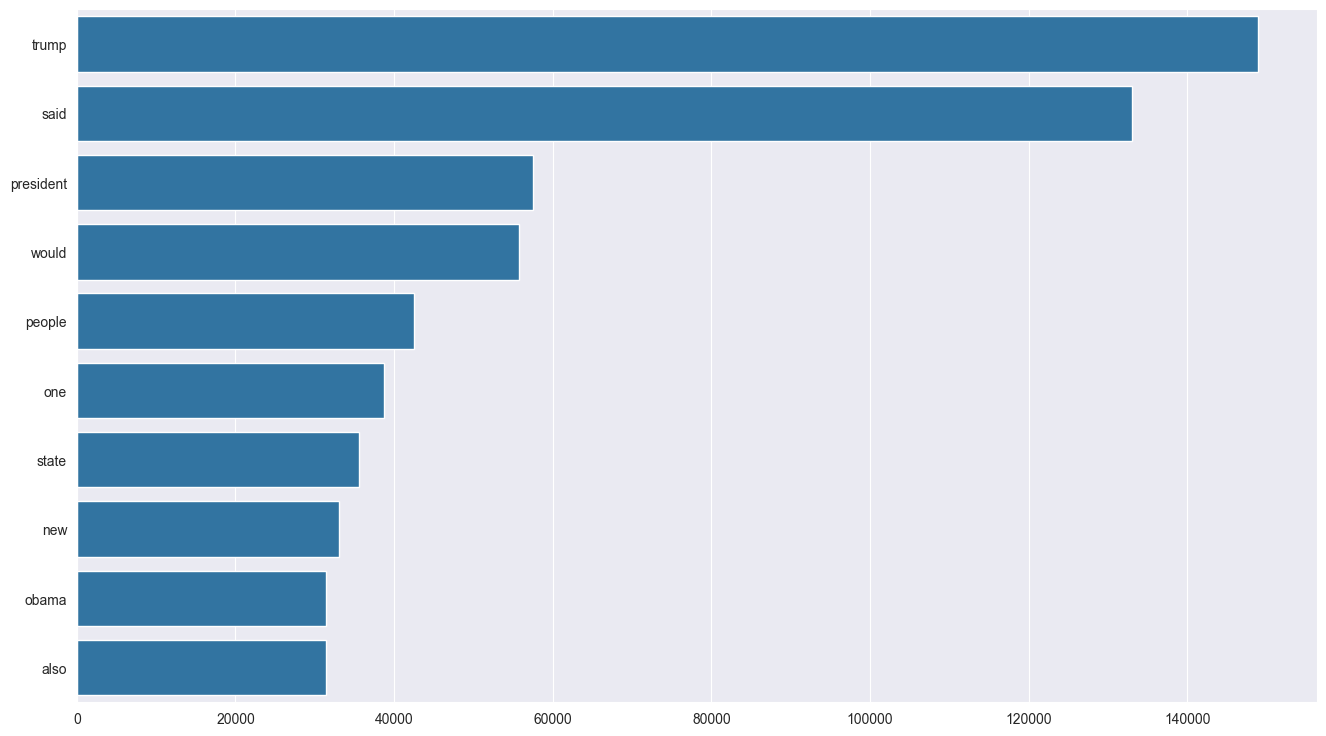

In [31]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(news.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<Axes: >

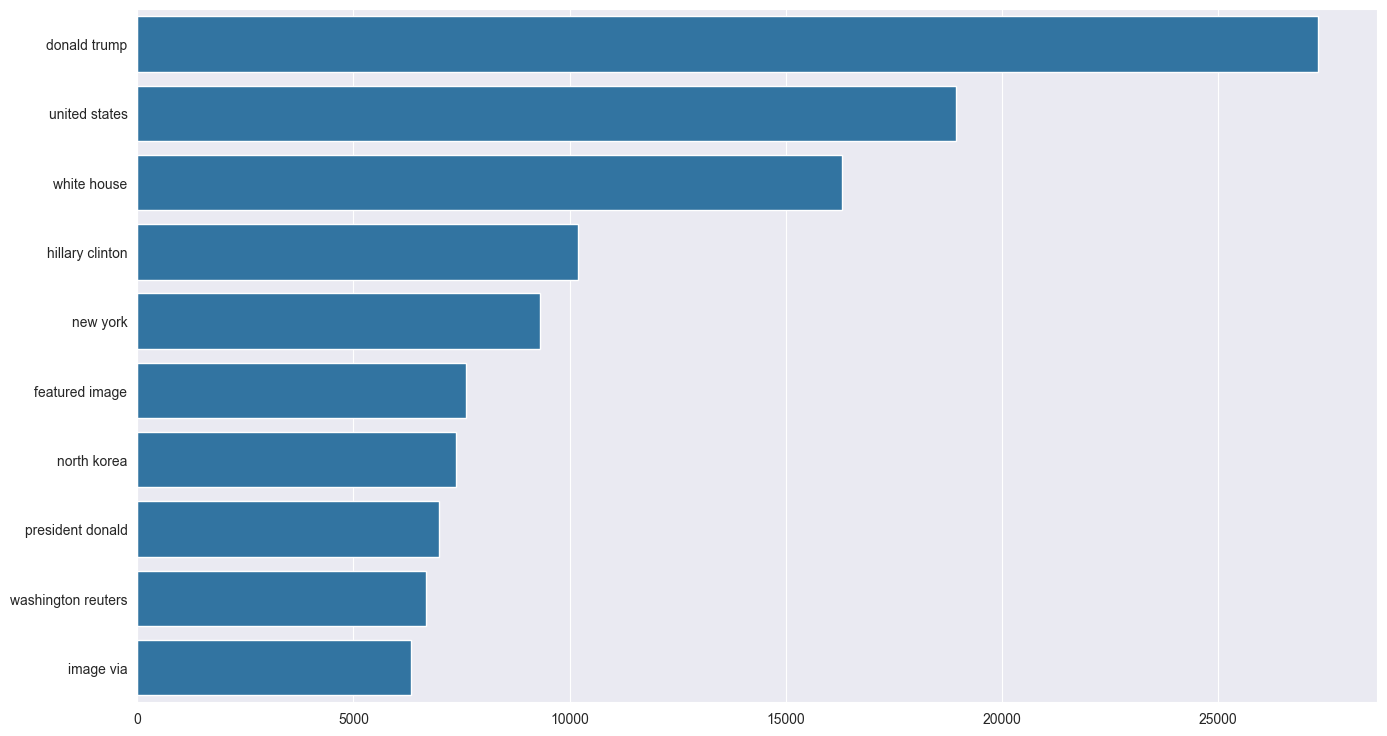

In [32]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(news.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

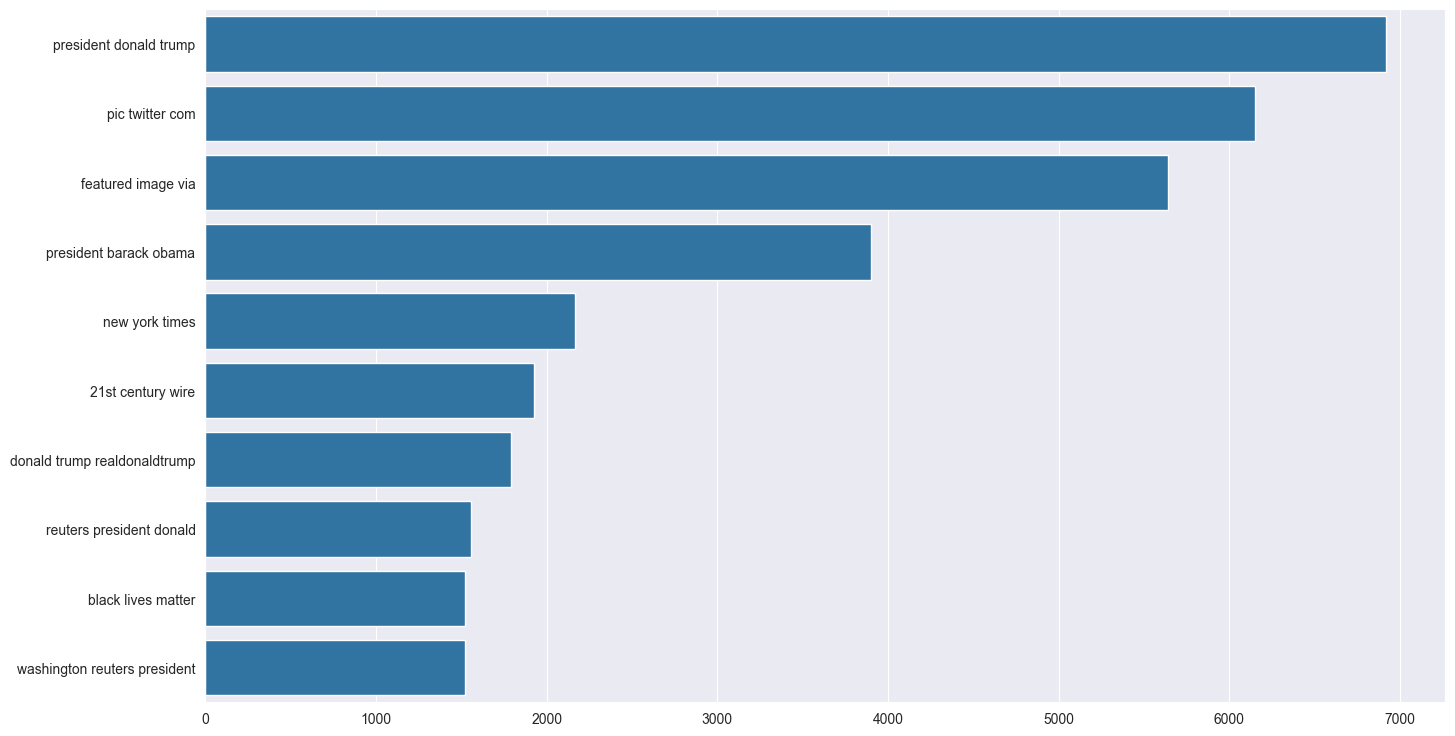

In [33]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(news.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

### model

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

texts_train, texts_test, labels_train, labels_test = train_test_split(news.text,news.label, test_size=0.2, random_state=1)

# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Create a Naive Bayes classifier
nb = MultinomialNB()

# Make a pipeline
model = make_pipeline(tfidf, nb)

# Train the model
model.fit(texts_train, labels_train)

# Make predictions
predictions = model.predict(texts_test)

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluation for Naive Bayes with TF-IDF
accuracy_nb = accuracy_score(labels_test, predictions)
precision_nb = precision_score(labels_test, predictions, pos_label=0)
recall_nb = recall_score(labels_test, predictions, pos_label=0)
f1_nb = f1_score(labels_test, predictions, pos_label=0)
conf_matrix_nb = confusion_matrix(labels_test, predictions)

print("Naive Bayes with TF-IDF:")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")
print("Confusion Matrix:")
print(conf_matrix_nb)

Naive Bayes with TF-IDF:
Accuracy: 0.9428
Precision: 0.9379
Recall: 0.9532
F1 Score: 0.9455
Confusion Matrix:
[[4459  219]
 [ 295 4007]]


In [40]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Logistic Regression with Doc2Vec
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(texts_train)]

# Train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=10)

# Infer vectors for training and testing data
X_train_doc2vec = [doc2vec_model.infer_vector(word_tokenize(doc.lower())) for doc in texts_train]
X_test_doc2vec = [doc2vec_model.infer_vector(word_tokenize(doc.lower())) for doc in texts_test]

# Create and train the Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_doc2vec, labels_train)

# Predictions
logreg_predictions = logreg_model.predict(X_test_doc2vec)

# Evaluate the Logistic Regression model
print("\nLogistic Regression with Doc2Vec:")


Logistic Regression with Doc2Vec:


In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluation for Naive Bayes with TF-IDF
accuracy_nb = accuracy_score(labels_test, predictions)
precision_nb = precision_score(labels_test, predictions, pos_label=0)
recall_nb = recall_score(labels_test, predictions, pos_label=0)
f1_nb = f1_score(labels_test, predictions, pos_label=0)
conf_matrix_nb = confusion_matrix(labels_test, predictions)

print("Naive Bayes with TF-IDF:")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")
print("Confusion Matrix:")
print(conf_matrix_nb)

Naive Bayes with TF-IDF:
Accuracy: 0.9428
Precision: 0.9379
Recall: 0.9532
F1 Score: 0.9455
Confusion Matrix:
[[4459  219]
 [ 295 4007]]


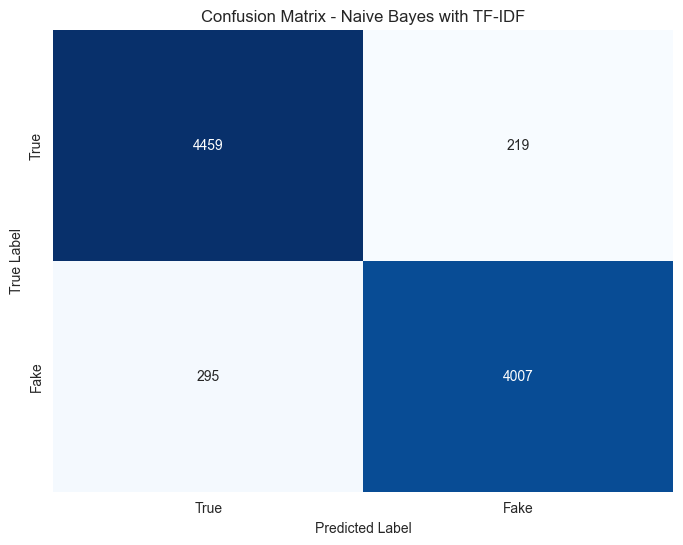

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix for Naive Bayes with TF-IDF
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.title('Confusion Matrix - Naive Bayes with TF-IDF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()